In [2]:
from IPython.display import Image

# Modulo 5: CRISP-DM - Modelaje

In [ ]:
Image("../Images/crisp_dm_1.png")

In [1]:
import pandas as pd
import MySQLdb as mdb
con=mdb.connect(user='root',database='meetup')
cursor = con.cursor()

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

# Clase 36
### Segundo las ventas:

- ¿Cuál es el tamaño de la compañía? (done)
- - Usuarios totales y usuarios activos. (abajo el query)
- ¿Cuánto crece la compañía? ¿Al año y al mes? done 
- - es decir ¿cuántos usuarios activos tenía el mes pasado, cuántos usuarios nuevos tengo este mes?. (done)  (abajo el query)
- - ¿cuántos usuarios activos tenía el mes pasado, cuántos usuarios activos tengo este mes?. 
- - para cada punto calcular el delta. 
- ¿Cómo se comporta este crecimiento? 
- - Lo primero es entender nivel país, estado, ciudad. (son filtros a tablas de crecimiento, o la opcion de tener listas desplegables) 
- - Surgiran preguntas como ¿Hay eventos en WeWork? (like, contiene "WeWork") 
- - - ¿ Cuántos eventos, usuarios, grupos, se celebran en WeWork?
- - - ¿ Como es la distribucion de estos eventos nivel país, estado, ciudad.



Antes de empezar vamos a hacer un ejercicio...

Vamos a intentar hacer el análisis con Excel... calculemos el número de usuarios mes a mes con la tabla members.
...
...
No abrió completa, sólo por eso debemos utilizar otra herramienta. En este caso vamos a usar un motor de base de datos, podríamos usar python, tableau o algúna otra opción.

Primero vamos a conocer nuestra base.


In [ ]:
pd.read_sql('show columns from meetup.members;', con)

In [ ]:
pd.read_sql('select * from meetup.members m limit 5;', con)

Vemos que tenemos member_id duplicados, vamos a crear una tabla en dónde conservermos un sólo id de cliente y para la fecha de registro conservemos la más antigua.

In [ ]:
pd.read_sql('select member_id, min(joined) as joined from meetup.members m group by member_id;', con)

In [79]:
cursor.execute("""
create table meetup.xxx_temp_members_1 as
select member_id, min(joined) as joined from meetup.members m group by member_id;
""")

1087923

In [77]:
pd.read_sql('select * from meetup.xxx_temp_members_1;', con)

,member_id,joined
0,3,2007-05-01 22:04:37
1,6,2006-03-08 16:33:41
2,36,2010-07-27 18:44:24
3,65,2012-03-20 05:29:10
4,82,2012-08-09 00:36:23
...,...,...
1087918,240845614,2017-11-09 16:39:43
1087919,240845866,2017-11-09 16:40:42
1087920,240846998,2017-11-09 16:51:53
1087921,240849026,2017-11-09 17:24:14


Ahora vamos a extraer el año y el mes de la fecha de registro (Podemos crear tablas auxiliares para que no tarde tanto la corrida de nuestros scripts)

In [ ]:
pd.read_sql('''select member_id, joined, year(joined) as anio, month(joined) as mes
from (select member_id, min(joined) as joined from meetup.members m group by member_id) x
''', con)

In [81]:
cursor.execute('''
create table meetup.xxx_temp_members_2 as
select member_id, joined, year(joined) as anio, month(joined) as mes
from meetup.xxx_temp_members_1
''')

1087923

Vamos a calcular el número de usuario por año

In [ ]:
pd.read_sql('''
select anio, count(member_id) freq from
(select member_id, joined, year(joined) as anio, month(joined) as mes
from (select member_id, min(joined) as joined from meetup.members m group by member_id) x) y
group by 1
''', con)

In [82]:
cursor.execute('''
create table meetup.xxx_temp_members_3 as
select anio, count(member_id) freq from
meetup.xxx_temp_members_2
group by 1
''')

16

Ahora queremos calcular el crecimiento por año, antes, para ello necesitamos "freq" rezagada en t-1 y "freq" en t, para luego hacer t/t-1 esto lo hacemos con la funcion LAG
para este caso la vamos a mover hacia adelante

In [ ]:
pd.read_sql('''
select 
*, 
LAG(freq,1) OVER (ORDER BY anio) AS freqt1
from (
select anio, count(member_id) freq from
(select member_id, joined, year(joined) as anio, month(joined) as mes
from (select member_id, min(joined) as joined from meetup.members m group by member_id) x) y
group by 1
) z
''', con)

In [83]:
cursor.execute('''
create table meetup.xxx_temp_members_4 as
select 
*, 
LAG(freq,1) OVER (ORDER BY anio) AS freqt1
from meetup.xxx_temp_members_3
''')

16

Una vez rezagada podemos calcular el crecimiento año a año

In [ ]:
pd.read_sql('''
select 
anio, freq, freqt1, (freq/freqt1-1) as growth_yoy
from (
select 
*, 
LAG(freq,1) OVER (ORDER BY anio) AS freqt1
from (
select anio, count(member_id) freq from
(select member_id, joined, year(joined) as anio, month(joined) as mes
from (select member_id, min(joined) as joined from meetup.members m group by member_id) x) y
group by 1
) z
) a
''', con)

In [85]:
cursor.execute('''
create table meetup.xxx_temp_members_5 as
select 
anio, freq, freqt1, (freq/freqt1-1) as growth_yoy
from meetup.xxx_temp_members_4
''')

16

Perfecto tenemos nuestro número, luego vamos a usar estas tablas para hacer gráficos en nuestro tablero. 
Así que vamos a guardar el número en una tabla

In [ ]:
cursor.execute('''drop table zzz_growth_yoy''')

In [ ]:
cursor.execute('''
create table zzz_growth_yoy as
select 
anio, freq, freqt1, (freq/freqt1-1) as growth_yoy
from (
select 
*, 
LAG(freq,1) OVER (ORDER BY anio) AS freqt1
from (
select anio, count(member_id) freq from
(select member_id, joined, year(joined) as anio, month(joined) as mes
from (select member_id, min(joined) as joined from meetup.members m group by member_id) x) y
group by 1
) z 
) a 
''')

# GRAFICAS 
1. zzz_growth_yoy
2. zzz_growth_mom

In [87]:
pd.read_sql("""
select * from xxx_temp_members_5
""", con)

,anio,freq,freqt1,growth_yoy
0,2002,65,NaN,NaN
1,2003,2043,65.0,30.4308
2,2004,1544,2043.0,-0.2442
3,2005,1753,1544.0,0.1354
4,2006,6461,1753.0,2.6857
5,2007,13683,6461.0,1.1178
6,2008,20832,13683.0,0.5225
7,2009,34254,20832.0,0.6443
8,2010,41026,34254.0,0.1977
9,2011,57331,41026.0,0.3974


In [86]:
pd.read_sql("""
select * from zzz_growth_yoy
""", con)

,anio,freq,freqt1,growth_yoy
0,2002,65,NaN,NaN
1,2003,2043,65.0,30.4308
2,2004,1544,2043.0,-0.2442
3,2005,1753,1544.0,0.1354
4,2006,6461,1753.0,2.6857
5,2007,13683,6461.0,1.1178
6,2008,20832,13683.0,0.5225
7,2009,34254,20832.0,0.6443
8,2010,41026,34254.0,0.1977
9,2011,57331,41026.0,0.3974


###  Oye vamos a resolver el siguiente reto, si quieres resolverlo tu mismo, dale pausa al video, e inténtalo.

Debes calcular el crecimiento en número de usuarios, mes a mes.

In [ ]:
cursor.execute("""
create table zzz_growth_mom as
select 
anio, mes, freq, freqt1, (freq/freqt1-1) as growth_mom
from (
select 
*, 
LAG(freq,1) OVER (ORDER BY anio,mes) AS freqt1
from (
select anio, mes, count(member_id) freq from
(select member_id, joined, year(joined) as anio, month(joined) as mes
from (select member_id, min(joined) as joined from meetup.members m group by member_id) x) y
group by 1,2
) z
) a
""")

In [ ]:
pd.read_sql("""select * from zzz_growth_mom""", con)

# Clase 37
### Ahora vamos a agregarle filtros a nuestras tablas de crecimiento para entender cómo se comporta cada estado y ciudad.
Probemos si basta con usar el código que ya escribimos arriba y agregarle las variables country, state, city.


In [ ]:
pd.read_sql('''
select country, state, city, anio, count(member_id) from
(select country, state, city, member_id, joined, year(joined) as anio, month(joined) as mes
from (select country, state, city, member_id, min(joined) as joined from meetup.members m group by member_id) x) y
group by 1,2,3,4
''', con).head(20)

In [90]:
cursor.execute("""
create table zzz_growth_yoy_filtros_geo as
select 
country, state, city, anio, freq, freqt1, (freq/freqt1-1) as growth_yoy
from (
select 
*, 
LAG(freq,1) OVER (ORDER BY freq) AS freqt1
from (
select country, state, city, anio, count(member_id) freq from
(select country, state, city, member_id, joined, year(joined) as anio
from (select country, state, city, member_id, min(joined) as joined from meetup.members m group by member_id) x) y
group by 1,2,3,4
) z
order by 1,2,3,4
) a
""")

131

In [ ]:
cursor.execute("""drop table zzz_growth_yoy_filtros_geo""")

In [ ]:
pd.read_sql("""
select * from zzz_growth_yoy_filtros_geo
order by 1,2,3,4
""",con)

In [103]:
pd.read_sql("""
select member_status, count(member_id) 
from meetup.members
group by 1
""",con)

,member_status,count(member_id)
0,active,5889254
1,prereg,4632


In [102]:
pd.read_sql("""
select member_status, count(distinct member_id)
from meetup.members
group by 1
""",con)

,member_status,count(distinct member_id)
0,active,1087230
1,prereg,695


Como ya teníamos nuestro query anterior lo único que debemos hacer es filtrar a los miembros activos desde nuestro pimer subquery.

In [96]:
cursor.execute("""
create table zzz_growth_yoy_filtros_geo_active as
select 
country, state, city, anio, freq, freqt1, (freq/freqt1-1) as growth_yoy
from (
select 
*, 
LAG(freq,1) OVER (ORDER BY freq) AS freqt1
from (
select country, state, city, anio, count(member_id) freq from
(select country, state, city, member_id, joined, year(joined) as anio
from (select country, state, city, member_id, min(joined) as joined from meetup.members m where member_status="active" group by member_id ) x) y
group by 1,2,3,4
) z
order by 1,2,3,4
) a
""")

131

In [ ]:
cursor.execute("""
drop table zzz_growth_yoy_filtros_geo_active as
""")

# GRAFICAS: 
3. zzz_growth_yoy_filtros_geo
4. zzz_growth_yoy_filtros_geo_active


Vamos a validar que efectivamente hicimos bien el query y estamos conservando solo usuarios activos

In [108]:
pd.read_sql(""" select sum(freq) from zzz_growth_yoy_filtros_geo_active """,con)

,sum(freq)
0,1087230.0


In [100]:
pd.read_sql(""" select sum(freq) from zzz_growth_yoy_filtros_geo """,con)

,sum(freq)
0,1087923.0


# Cuántos eventos se celebran en WeWork

### CRUZAR meetup, groups, events, venues

joins:

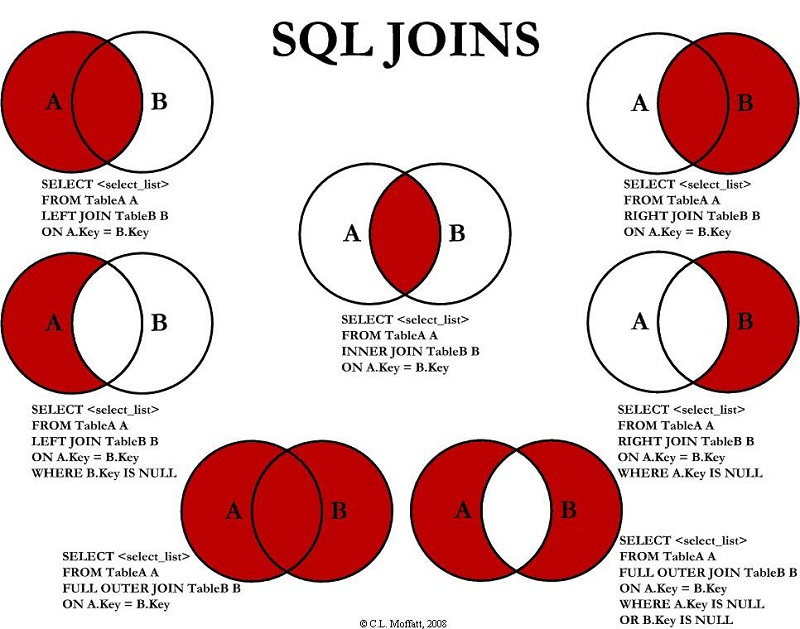

In [3]:
Image('../images/sqljoin.jpeg')

In [106]:
pd.read_sql("""
select count(*) from meetup.venues
where venue_name like '%WeWork%';""",con)

,count(*)
0,757


Cuántos eventos se celebran en todo lado

In [107]:
pd.read_sql("""
select count(*) from meetup.venues
""",con)

,count(*)
0,107093


# GRAFICA
5. zzz_growth_yoy_filtros_geo_wework.